<img src='https://drive.google.com/uc?id=1tqYIvII8lJ_FnqE6ugS21n4s93kMwTLy' />

## Machine Learning
## School of Computing and Engineering, University of West London
## Massoud Zolgharni

# Tutorial: k-Nearest Neighbor (kNN) for Image Classification
The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this tutorial, you will implement these steps and understand the basic Image Classification pipeline.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
FolderName = '/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/'
#import sys
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#%cd /content/gdrive/My Drive/Colab Notebooks
#!ls

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load the raw CIFAR-10 data.



In [ ]:
def load_CIFAR_batch(filename):
  # load single batch of cifar
  print(filename)
  with open(filename, 'rb') as f:
    datadict = pickle.load(f,encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

In [ ]:
def load_CIFAR10(ROOT):
  # load all of cifar
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [ ]:
"""
    You can download the CIFAR-10 dataset from here:

    https://drive.google.com/drive/folders/17WRyo0Gduv2YppY8gIQhbUBe-LdLhZYJ?usp=sharing

    Then put all files in a folder on your Google Drive or disk, and load it to perform preprocessing to prepare
    it for the classifier.
"""

X_train, y_train, X_test, y_test = load_CIFAR10('/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/')

/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/data_batch_1
/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/data_batch_2
/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/data_batch_3
/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/data_batch_4
/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/data_batch_5
/content/gdrive/My Drive/Colab Notebooks/UWL/ML_L6/CIFAR10/test_batch


## As a sanity check, we print out the size of the training and test data.

In [ ]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualise some examples from the dataset.
We show a few examples of training images from each class.

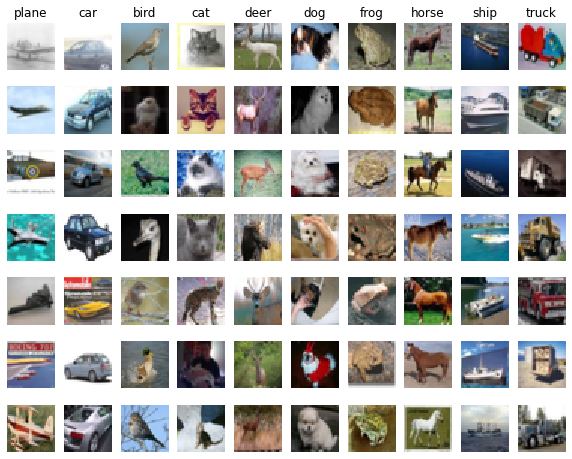

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the data
There are 50,000 images in the training dataset. Let us use only 5,000 images for more efficient code execution in this exercise.

Similarly, only 500 images from the test dataset is used.

In [ ]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
X_train.shape

(5000, 32, 32, 3)

## Reshape the image data into rows

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [ ]:
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## kNN classifier
We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

- First we must compute the distances between all test examples and all train examples.
- Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are Ntr training examples and Nte test examples, this stage should result in a Nte x Ntr matrix where each element (i,j) is the distance between the i-th test and j-th train example.

In [ ]:
class KNearestNeighbor(object):
  # a kNN classifier with L2 distance

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):

        # Compute the l2 distance between the ith test point and the jth
        # training point, and store the result in dists[i, j]. You should
        # not use a loop over dimension.

        dists[i, j] = np.sqrt(np.sum((X[i, :] - self.X_train[j, :]) **2))

    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):

      # Compute the l2 distance between the ith test point and all training
      # points, and store the result in dists[i, :].

      dists[i, :] = np.sqrt(np.sum((self.X_train - X[i, :])**2, axis=1))

    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # Compute the l2 distance between all test points and all training
    # points without using any explicit loops, and store the result in dists.

    # You should implement this function using only basic array operations;
    # in particular you should not use functions from scipy.
    # HINT: Try to formulate the l2 distance using matrix multiplication and two broadcast sums.

    dists = np.sqrt((-2 * np.dot(X, self.X_train.T)) + np.sum(X**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1))

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []

      # Use the distance matrix to find the k nearest neighbors of the ith
      # testing point, and use self.y_train to find the labels of these
      # neighbors. Store these labels in closest_y.
      # Hint: Look up the function numpy.argsort.

      k_nearest_idxs = np.argsort(dists[i, :])[:k]
      closest_y = self.y_train[k_nearest_idxs]

      # Now that you have found the labels of the k nearest neighbors, you
      # need to find the most common label in the list closest_y of labels.
      # Store this label in y_pred[i]. Break ties by choosing the smaller
      # label.

      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred

## Create a kNN classifier instance.
Remember that training a kNN classifier is a noop:

The Classifier simply remembers the data and does no further processing

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

## Test your implementation:

In [ ]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


We can visualize the distance matrix: each row is a single test example and its distances to training examples

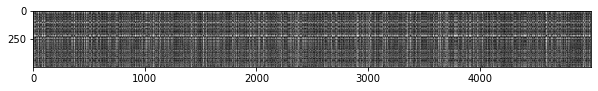

In [ ]:
plt.imshow(dists, interpolation='none')
plt.show()

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter.

Note that with the default color scheme black indicates low distances while white indicates high distances.

- What in the data is the cause behind the distinctly bright rows?
- What does each column and each row respresent?

Now implement the function predict_labels and run the code below:

We use k = 1 (which is Nearest Neighbor).

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=1)

Compute and print the fraction of correctly predicted examples

In [ ]:
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately 26% accuracy. Now lets try out a larger k, say k = 5:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

Now lets speed up distance matrix computation by using partial vectorization with one loop.

Let us run the function compute_distances_one_loop and run the code below:

In [ ]:
dists_one = classifier.compute_distances_one_loop(X_test)

To ensure that our vectorised implementation is correct, we make sure that it agrees with the naive implementation. There are many ways to decide whether two matrices are similar; one of the simplest is the Frobenius norm.

In case you haven't seen it before, the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements; in other words, reshape the matrices into vectors and compute the Euclidean distance between them.

In [ ]:
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Now implement the fully vectorised version inside compute_distances_no_loops and run the code

In [ ]:
dists_two = classifier.compute_distances_no_loops(X_test)

Check that the distance matrix agrees with the one we computed before:

In [ ]:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Let us compare how fast the implementations are

In [ ]:
def time_function(f, *args):

    # Call a function f with args and return the time (in seconds) that it took to execute.
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

In [ ]:
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two-loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One-loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No-loop version took %f seconds' % no_loop_time)

Two-loop version took 34.255379 seconds
One-loop version took 25.804538 seconds
No-loop version took 0.518989 seconds


You should see significantly faster performance with the fully vectorised implementation.

## Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily.

We will now determine the best value of this hyperparameter with cross-validation.

Split up the training data into folds.

After splitting, X_train_folds and y_train_folds should each be lists of length num_folds, where y_train_folds[i] is the label vector for the points in X_train_folds[i].     

Hint: Look up the numpy array_split function.   

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 7, 9, 11, 13, 15]

X_train_folds = []
y_train_folds = []

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

A dictionary holding the accuracies for different values of k that we find when running cross-validation.

After running cross-validation, k_to_accuracies[k] should be a list of length num_folds giving the different accuracy values that we found when using that value of k.

Perform k-fold cross validation to find the best value of k.

For each possible value of k, run the k-nearest-neighbor algorithm num_folds times, where in each case you use all but one of the folds as training data and the last fold as a validation set.

Store the accuracies for all fold and all values of k in the k_to_accuracies dictionary.

In [ ]:
k_to_accuracies = {}
num_split = X_train.shape[0] / num_folds
acc_k = np.zeros((len(k_choices), num_folds), dtype=np.float)

In [ ]:
for ik ,k in enumerate(k_choices):
    for i in range(num_folds):
        train_set = np.concatenate((X_train_folds[:i]+X_train_folds[i+1:]))
        label_set = np.concatenate((y_train_folds[:i]+y_train_folds[i+1:]))
        classifier.train(train_set, label_set)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        acc_k[ik, i] = float(num_correct) / num_split
    k_to_accuracies[k] = acc_k[ik]

Print out the computed accuracies

In [ ]:
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 7, accuracy = 0.261000
k = 7, accuracy = 0.279000
k = 7, accuracy = 0.268000
k = 7, accuracy = 0.288000
k = 7, accuracy = 0.276000
k = 9, accuracy = 0.259000
k = 9, accuracy = 0.283000
k = 9, accuracy = 0.270000
k = 9, accuracy = 0.285000
k = 9, accuracy = 0.285000
k = 11, accuracy = 0.265000
k = 11, accuracy = 0.296000
k = 11, accuracy = 0.277000
k = 11, accuracy = 0.279000
k = 11, accuracy = 0.270000
k = 13, accuracy = 0.262000
k = 13, accuracy = 0.291000
k = 13, accuracy = 0.273000
k = 13, accuracy = 0.274000
k = 13, accuracy = 0.273000
k = 15, accuracy = 0.252000
k = 15, accuracy 

Plot the raw observations

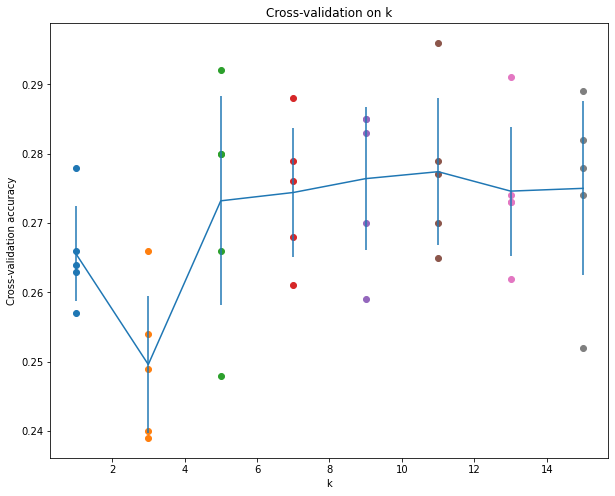

In [ ]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

# Your task

Based on the cross-validation results above, choose the best value for k, retrain the classifier using **half** the training data, and test it on **all** the test data.

In [ ]:
#best_k = # your code here
# load the original data...

#classifier = KNearestNeighbor()
#classifier.train(# your code here)
#y_test_pred = classifier.predict(# your code here)

Compute and display the accuracy

In [ ]:
#num_correct = # your code here
#accuracy = # your code here
#print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))